# Train the networks for modulation recognition

## Preambule

In [1]:
# Authors: Helion du Mas des Bourboux <helion.dumasdesbourboux'at'thalesgroup.com>
#         Thomas Courtat <thomas.courtat'at'thalesgroup.com>
#
# MIT License
#
# Copyright (c) 2022 THALES
#   All Rights Reserved.
#
# Permission is hereby granted, free of charge, to any person obtaining a copy
# of this software and associated documentation files (the "Software"), to deal
# in the Software without restriction, including without limitation the rights
# to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
# copies of the Software, and to permit persons to whom the Software is
# furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in all
# copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
# AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
# OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
# SOFTWARE.
#
# 2022 November 25

### Imports

In [2]:
import sys
from os import mkdir
from os.path import exists as path_exists
from os.path import join
import time

import numpy as np
import matplotlib.pyplot as plt

plt.rcParams["pdf.fonttype"] = 42

import tensorflow.keras
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical
from tensorflow.python.client import device_lib
from tensorflow import convert_to_tensor
from tensorflow.keras.backend import clear_session

print(f"Available devices:\n{[x.name for x in device_lib.list_local_devices()]}")

from pythagore_modreco.data import read_augmod, read_RML2016, read_RML2018
from pythagore_modreco.utils import TimeHistory, split_dataset
from pythagore_modreco import neural_nets_keras

Available devices:
['/device:CPU:0', '/device:GPU:0', '/device:GPU:1', '/device:GPU:2']


In [3]:
for lib in ["tensorflow", "numpy", "matplotlib", "pythagore_modreco"]:
    print(f"{lib} version = {__import__(lib).__version__}")

tensorflow version = 2.6.0
numpy version = 1.19.5
matplotlib version = 3.4.3
pythagore_modreco version = 0.0.6


In [4]:
np.random.seed(2015)

### General settings

In [5]:
# Please specify the folder where your dataset(s) is/are
data_path = <your data path>

# Please specify a folder to log information during model training 
log_path = <your log path>

if not path_exists(log_path):
    mkdir(log_path)

#### Dataset settings

In [6]:
# Please chose a dataset name from:
# AugMod
# RadioML2016.04c
# RadioML2016.10a
# RadioML2016.10b
# RadioML2018.01a
dataset_name = "AugMod"

# Please choose signal duration in seconds.
# Beware, that duration should be less or equal to the chosen dataset signal lengths
# Set to None if you want to take as much as there is in the dataset
signal_duration = 128

# Please choose a cut in SNR
# The resulting dataset will consit in all data>=snr_cut
# set to None if no cut
snr_cut = 0.0

#### Trainning settings

In [7]:
nb_epoch = 200
batch_size = 512

## Data loading and preparation

Load the selected dataset ; 

This cell outputs: 
- signals : a numpy array containing signal data 
- class_onehot : a numpy array containing one hot encoded labels associated to data 
- snrs: an array associating snr to each signal 
- class_list: a list of strings associating the modulation / signal kind name to the indexes of labels

In [8]:
if dataset_name == "AugMod":

    fName = join(data_path, "augmod.hdf5")
    data_dict = read_augmod(fName)

    signals = data_dict["signals"]
    class_idx = data_dict["modulations"]
    snrs = data_dict["snr"]

    class_onehot = to_categorical(class_idx)
    class_list = data_dict["classes"]

elif dataset_name == "RadioML2016.04c":

    fName = join(data_path, "2016.04C.multisnr.pkl")

    signals, class_idx, snrs, class_list = read_RML2016(fName)
    class_onehot = to_categorical(class_idx)

elif dataset_name == "RadioML2016.10a":

    fName = join(data_path, "RML2016.10a_dict.pkl")

    signals, class_idx, snrs, class_list = read_RML2016(fName)
    class_onehot = to_categorical(class_idx)

elif dataset_name == "RadioML2016.10b":

    fName = join(data_path, "RML2016.10b.dat")

    signals, class_idx, snrs, class_list = read_RML2016(fName)
    class_onehot = to_categorical(class_idx)

elif dataset_name == "RadioML2018.01a":

    fName = join(data_path, "GOLD_XYZ_OSC.0001_1024.hdf5")

    signals, class_onehot, snrs, class_list = read_RML2018(fName)
    # snrs = snrs.reshape(-1)
    class_idx = np.argmax(class_onehot, axis=-1)
else:
    print("Data not found")

In [9]:
snrs_list = sorted(list(set(snrs)))
print(
    f"{dataset_name} loaded, {signals.shape[0]} signal with shape {signals.shape[1:]}"
)
print(f"List of signal SNR: {snrs_list}")
print(f"List of modulations under consideration: {class_list}")

AugMod loaded, 174720 signal with shape (2, 1024)
List of signal SNR: [0.0, 10.0, 20.0, 30.0, 40.0]
List of modulations under consideration: ['BPSK', 'PSK8', 'QAM16', 'QAM32', 'QAM64', 'QAM8', 'QPSK']


Transposes the data so the real/imag axis is the last as expected by deep learning models

In [10]:
print(f"Initial data shape: {signals.shape}")
signals = signals.transpose((0, 2, 1))
print(f"Transposed data shape: {signals.shape}")

Initial data shape: (174720, 2, 1024)
Transposed data shape: (174720, 1024, 2)


Trunk signal to `signal_duration`samples. 

In [11]:
if not signal_duration is None:
    print(f"Initial data shape: {signals.shape}")
    signals = signals[:, :signal_duration, :]
    print(f"Trunked data shape: {signals.shape}")

Initial data shape: (174720, 1024, 2)
Trunked data shape: (174720, 128, 2)


Filters signal by snr if requested above

In [12]:
if not snr_cut is None:
    print(f"Initial data shape: {signals.shape}")
    w = snrs >= snr_cut
    signals = signals[w]
    class_idx = class_idx[w]
    snrs = snrs[w]
    class_onehot = class_onehot[w]
    print(f"New data shape: {signals.shape}")

Initial data shape: (174720, 128, 2)
New data shape: (174720, 128, 2)


Normalize the power of each signal

In [13]:
### Normalize the power of each signal
norm = np.sqrt(np.mean(signals**2, axis=(1, 2), keepdims=True))
signals /= norm

Split dataset into train and test sets. Also shuffles data.

In [14]:
X_train, y_train, train_idx, _, _, _, X_test, y_test, test_idx = split_dataset(
    signals, class_onehot, p_train=0.5, p_test=0.5
)

SNR_train = snrs[train_idx]
SNR_test = snrs[test_idx]

print(f"Train dataset shape: {X_train.shape}")
print(f"Test dataset shape: {X_test.shape} ")

Train dataset shape: (87360, 128, 2)
Test dataset shape: (87360, 128, 2) 


In [15]:
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test  shape: {X_test.shape}, y_test  shape: {y_test.shape}")

input_shp = list(X_train.shape[1:])
output_shp = y_train.shape[1]

print(f"Network input shape in variable input-shp: {input_shp}")
print(f"Network output shape in variable input-shp: {output_shp}")

X_train shape: (87360, 128, 2), y_train shape: (87360, 7)
X_test  shape: (87360, 128, 2), y_test  shape: (87360, 7)
Network input shape in variable input-shp: [128, 2]
Network output shape in variable input-shp: 7


In [16]:
X_train = convert_to_tensor(X_train)
y_train = convert_to_tensor(y_train)
X_test = convert_to_tensor(X_test)
y_test = convert_to_tensor(y_test)

## Deep learning model training 

Define a function to instanciate and train a deep learning model

In [17]:
def train_model(model, name_network):

    clear_session()
    time_callback = TimeHistory()

    history = model.fit(
        X_train,
        y_train,
        epochs=nb_epoch,
        batch_size=batch_size,
        validation_data=(X_test, y_test),
        verbose=1,
        callbacks=[time_callback],
    )

    model.save(
        join(
            log_path,
            "model-{}-{}-trained{}.h5".format(
                dataset_name, name_network, signal_duration
            ),
        )
    )

    data = np.array(
        list(
            zip(
                history.epoch,
                history.history["val_accuracy"],
                history.history["accuracy"],
            )
        )
    )
    np.savetxt(
        join(
            log_path,
            "history-{}-{}-trained{}.txt".format(
                dataset_name, name_network, signal_duration
            ),
        ),
        data,
    )

    data = np.array(list(zip(history.epoch, time_callback.times)))
    np.savetxt(
        join(
            log_path,
            "history_time-{}-{}-trained{}.txt".format(
                dataset_name, name_network, signal_duration
            ),
        ),
        data,
    )

    clear_session()

### LModCNN (ours)

Generate LModCNN architecture as defined in Courtat and du Mas des Bourboux, <i>A light neural network for modulation detection under impairments</i>, ISNCC 2021


In [18]:
name_network = "LModCNN"

dynamic_input_shp = input_shp.copy()
dynamic_input_shp[0] = None

model = getattr(neural_nets_keras, "get_{}".format(name_network))(
    dynamic_input_shp, output_shp
)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, None, 8)           120       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          912       
_________________________________________________________________
conv1d_2 (Conv1D)            (None, None, 32)          3616      
_________________________________________________________________
conv1d_3 (Conv1D)            (None, None, 64)          14400     
_________________________________________________________________
global_average_pooling1d (Gl (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 256)               16640     
_________________________________________________________________
dropout (Dropout)            (None, 256)               0

In [19]:
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
train_model(model, name_network)

Epoch 1/200
171/171 [==============================] - 5s 17ms/step - loss: 1.8074 - accuracy: 0.2183 - val_loss: 1.6084 - val_accuracy: 0.2753
Epoch 2/200
171/171 [==============================] - 2s 13ms/step - loss: 1.6031 - accuracy: 0.2801 - val_loss: 1.5871 - val_accuracy: 0.2953
Epoch 3/200
171/171 [==============================] - 2s 14ms/step - loss: 1.5721 - accuracy: 0.3035 - val_loss: 1.5413 - val_accuracy: 0.3269
Epoch 4/200
171/171 [==============================] - 2s 13ms/step - loss: 1.4889 - accuracy: 0.3443 - val_loss: 1.4074 - val_accuracy: 0.3744
Epoch 5/200
171/171 [==============================] - 2s 14ms/step - loss: 1.3581 - accuracy: 0.3875 - val_loss: 1.2842 - val_accuracy: 0.4133
Epoch 6/200
171/171 [==============================] - 2s 13ms/step - loss: 1.2827 - accuracy: 0.4130 - val_loss: 1.2290 - val_accuracy: 0.4338
Epoch 7/200
171/171 [==============================] - 2s 13ms/step - loss: 1.2281 - accuracy: 0.4292 - val_loss: 1.2218 - val_accuracy:

171/171 [==============================] - 2s 14ms/step - loss: 0.8333 - accuracy: 0.6213 - val_loss: 0.8339 - val_accuracy: 0.6184
Epoch 58/200
171/171 [==============================] - 2s 14ms/step - loss: 0.8292 - accuracy: 0.6225 - val_loss: 0.8301 - val_accuracy: 0.6195
Epoch 59/200
171/171 [==============================] - 2s 14ms/step - loss: 0.8314 - accuracy: 0.6234 - val_loss: 0.8535 - val_accuracy: 0.6095
Epoch 60/200
171/171 [==============================] - 2s 14ms/step - loss: 0.8316 - accuracy: 0.6229 - val_loss: 0.8363 - val_accuracy: 0.6195
Epoch 61/200
171/171 [==============================] - 2s 13ms/step - loss: 0.8250 - accuracy: 0.6265 - val_loss: 0.8386 - val_accuracy: 0.6184
Epoch 62/200
171/171 [==============================] - 2s 14ms/step - loss: 0.8263 - accuracy: 0.6257 - val_loss: 0.8241 - val_accuracy: 0.6259
Epoch 63/200
171/171 [==============================] - 2s 14ms/step - loss: 0.8223 - accuracy: 0.6274 - val_loss: 0.8370 - val_accuracy: 0.621

171/171 [==============================] - 2s 13ms/step - loss: 0.7072 - accuracy: 0.6948 - val_loss: 0.7218 - val_accuracy: 0.6926
Epoch 114/200
171/171 [==============================] - 2s 14ms/step - loss: 0.7029 - accuracy: 0.6972 - val_loss: 0.7104 - val_accuracy: 0.6934
Epoch 115/200
171/171 [==============================] - 2s 14ms/step - loss: 0.6990 - accuracy: 0.6987 - val_loss: 0.7037 - val_accuracy: 0.6975
Epoch 116/200
171/171 [==============================] - 2s 14ms/step - loss: 0.6958 - accuracy: 0.7003 - val_loss: 0.7097 - val_accuracy: 0.6970
Epoch 117/200
171/171 [==============================] - 2s 14ms/step - loss: 0.6926 - accuracy: 0.7019 - val_loss: 0.7020 - val_accuracy: 0.6973
Epoch 118/200
171/171 [==============================] - 2s 13ms/step - loss: 0.6934 - accuracy: 0.6997 - val_loss: 0.6935 - val_accuracy: 0.7020
Epoch 119/200
171/171 [==============================] - 2s 14ms/step - loss: 0.6902 - accuracy: 0.7041 - val_loss: 0.6988 - val_accuracy:

171/171 [==============================] - 2s 14ms/step - loss: 0.6146 - accuracy: 0.7349 - val_loss: 0.6727 - val_accuracy: 0.7107
Epoch 170/200
171/171 [==============================] - 2s 14ms/step - loss: 0.6143 - accuracy: 0.7369 - val_loss: 0.6598 - val_accuracy: 0.7208
Epoch 171/200
171/171 [==============================] - 2s 14ms/step - loss: 0.6167 - accuracy: 0.7356 - val_loss: 0.6602 - val_accuracy: 0.7198
Epoch 172/200
171/171 [==============================] - 2s 14ms/step - loss: 0.6094 - accuracy: 0.7391 - val_loss: 0.6680 - val_accuracy: 0.7162
Epoch 173/200
171/171 [==============================] - 2s 13ms/step - loss: 0.6114 - accuracy: 0.7374 - val_loss: 0.6613 - val_accuracy: 0.7211
Epoch 174/200
171/171 [==============================] - 2s 13ms/step - loss: 0.6143 - accuracy: 0.7356 - val_loss: 0.6677 - val_accuracy: 0.7193
Epoch 175/200
171/171 [==============================] - 2s 14ms/step - loss: 0.6073 - accuracy: 0.7394 - val_loss: 0.6573 - val_accuracy:

### LModCNNResNet Relu (ours)

Generate LModCNN with residual connexion architecture as defined in Courtat and du Mas des Bourboux, <i>A light neural network for modulation detection under impairments</i>, ISNCC 2021

In [20]:
name_network = "LModCNNResNetRelu"

dynamic_input_shp = input_shp.copy()
dynamic_input_shp[0] = None

model = getattr(neural_nets_keras, "get_{}".format(name_network))(
    dynamic_input_shp, output_shp
)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, 2)]    0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, None, 8)      24          input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, None, 8)      456         conv1d[0][0]                     
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, None, 8)      456         conv1d_1[0][0]                   
______________________________________________________________________________________________

In [21]:
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
train_model(model, name_network)

Epoch 1/200
171/171 [==============================] - 7s 34ms/step - loss: 1.7322 - accuracy: 0.2507 - val_loss: 1.4358 - val_accuracy: 0.3828
Epoch 2/200
171/171 [==============================] - 5s 29ms/step - loss: 1.2811 - accuracy: 0.4141 - val_loss: 1.2341 - val_accuracy: 0.4276
Epoch 3/200
171/171 [==============================] - 5s 30ms/step - loss: 1.1466 - accuracy: 0.4692 - val_loss: 1.1171 - val_accuracy: 0.4848
Epoch 4/200
171/171 [==============================] - 5s 29ms/step - loss: 1.0789 - accuracy: 0.5055 - val_loss: 1.0707 - val_accuracy: 0.5083
Epoch 5/200
171/171 [==============================] - 5s 28ms/step - loss: 1.0416 - accuracy: 0.5254 - val_loss: 1.0108 - val_accuracy: 0.5325
Epoch 6/200
171/171 [==============================] - 5s 29ms/step - loss: 0.9919 - accuracy: 0.5493 - val_loss: 1.1506 - val_accuracy: 0.4802
Epoch 7/200
171/171 [==============================] - 5s 29ms/step - loss: 0.9723 - accuracy: 0.5610 - val_loss: 0.9257 - val_accuracy:

171/171 [==============================] - 5s 27ms/step - loss: 0.6207 - accuracy: 0.7328 - val_loss: 0.6695 - val_accuracy: 0.7132
Epoch 58/200
171/171 [==============================] - 5s 28ms/step - loss: 0.6152 - accuracy: 0.7339 - val_loss: 0.6701 - val_accuracy: 0.7160
Epoch 59/200
171/171 [==============================] - 5s 28ms/step - loss: 0.6152 - accuracy: 0.7356 - val_loss: 0.6675 - val_accuracy: 0.7159
Epoch 60/200
171/171 [==============================] - 5s 28ms/step - loss: 0.6119 - accuracy: 0.7366 - val_loss: 0.6684 - val_accuracy: 0.7154
Epoch 61/200
171/171 [==============================] - 5s 28ms/step - loss: 0.6103 - accuracy: 0.7354 - val_loss: 0.6573 - val_accuracy: 0.7187
Epoch 62/200
171/171 [==============================] - 5s 27ms/step - loss: 0.6044 - accuracy: 0.7386 - val_loss: 0.6511 - val_accuracy: 0.7217
Epoch 63/200
171/171 [==============================] - 5s 28ms/step - loss: 0.6031 - accuracy: 0.7397 - val_loss: 0.6692 - val_accuracy: 0.714

171/171 [==============================] - 5s 30ms/step - loss: 0.5042 - accuracy: 0.7795 - val_loss: 0.7059 - val_accuracy: 0.7259
Epoch 114/200
171/171 [==============================] - 5s 30ms/step - loss: 0.5043 - accuracy: 0.7808 - val_loss: 0.7137 - val_accuracy: 0.7249
Epoch 115/200
171/171 [==============================] - 5s 30ms/step - loss: 0.4963 - accuracy: 0.7825 - val_loss: 0.7364 - val_accuracy: 0.7230
Epoch 116/200
171/171 [==============================] - 5s 30ms/step - loss: 0.5030 - accuracy: 0.7808 - val_loss: 0.7026 - val_accuracy: 0.7278
Epoch 117/200
171/171 [==============================] - 5s 31ms/step - loss: 0.4999 - accuracy: 0.7816 - val_loss: 0.7175 - val_accuracy: 0.7260
Epoch 118/200
171/171 [==============================] - 5s 30ms/step - loss: 0.4988 - accuracy: 0.7825 - val_loss: 0.7130 - val_accuracy: 0.7247
Epoch 119/200
171/171 [==============================] - 5s 30ms/step - loss: 0.5011 - accuracy: 0.7820 - val_loss: 0.7116 - val_accuracy:

171/171 [==============================] - 5s 29ms/step - loss: 0.4308 - accuracy: 0.8104 - val_loss: 0.8609 - val_accuracy: 0.7251
Epoch 170/200
171/171 [==============================] - 5s 28ms/step - loss: 0.4392 - accuracy: 0.8077 - val_loss: 0.9031 - val_accuracy: 0.7226
Epoch 171/200
171/171 [==============================] - 5s 28ms/step - loss: 0.4382 - accuracy: 0.8063 - val_loss: 0.8637 - val_accuracy: 0.7238
Epoch 172/200
171/171 [==============================] - 5s 28ms/step - loss: 0.4300 - accuracy: 0.8108 - val_loss: 0.8860 - val_accuracy: 0.7244
Epoch 173/200
171/171 [==============================] - 5s 28ms/step - loss: 0.4435 - accuracy: 0.8061 - val_loss: 0.8984 - val_accuracy: 0.7201
Epoch 174/200
171/171 [==============================] - 5s 28ms/step - loss: 0.4367 - accuracy: 0.8090 - val_loss: 0.9079 - val_accuracy: 0.7226
Epoch 175/200
171/171 [==============================] - 5s 27ms/step - loss: 0.4309 - accuracy: 0.8107 - val_loss: 0.8468 - val_accuracy:

/home/helion/.local/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


### RMLConvNet

Generate RMLConvNet as defined in O'Shea et Al., <i>Convolutional radio modulation recognition networks</i>, 2016
The implementation is an adaptation of
https://github.com/radioML/examples/blob/master/modulation_recognition/RML2016.10a_VTCNN2_example.ipynb


In [22]:
name_network = "RMLConvNet"

model = getattr(neural_nets_keras, "get_{}".format(name_network))(input_shp, output_shp)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 128, 2, 1)         0         
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 132, 2, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 130, 2, 256)       1024      
_________________________________________________________________
dropout (Dropout)            (None, 130, 2, 256)       0         
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 134, 2, 256)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 132, 1, 80)        122960    
_________________________________________________________________
dropout_1 (Dropout)          (None, 132, 1, 80)        0

In [23]:
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
train_model(model, name_network)

Epoch 1/200
171/171 [==============================] - 8s 44ms/step - loss: 1.7688 - accuracy: 0.2239 - val_loss: 1.6005 - val_accuracy: 0.2851
Epoch 2/200
171/171 [==============================] - 7s 42ms/step - loss: 1.5014 - accuracy: 0.3398 - val_loss: 1.2398 - val_accuracy: 0.4561
Epoch 3/200
171/171 [==============================] - 7s 43ms/step - loss: 1.2250 - accuracy: 0.4504 - val_loss: 1.1006 - val_accuracy: 0.4947
Epoch 4/200
171/171 [==============================] - 7s 42ms/step - loss: 1.1130 - accuracy: 0.4939 - val_loss: 1.0179 - val_accuracy: 0.5306
Epoch 5/200
171/171 [==============================] - 7s 41ms/step - loss: 1.0591 - accuracy: 0.5212 - val_loss: 0.9738 - val_accuracy: 0.5604
Epoch 6/200
171/171 [==============================] - 7s 43ms/step - loss: 1.0364 - accuracy: 0.5318 - val_loss: 0.9766 - val_accuracy: 0.5520
Epoch 7/200
171/171 [==============================] - 7s 41ms/step - loss: 1.0053 - accuracy: 0.5445 - val_loss: 0.9433 - val_accuracy:

171/171 [==============================] - 7s 41ms/step - loss: 0.6932 - accuracy: 0.7152 - val_loss: 0.8859 - val_accuracy: 0.5970
Epoch 58/200
171/171 [==============================] - 7s 42ms/step - loss: 0.6880 - accuracy: 0.7142 - val_loss: 0.8839 - val_accuracy: 0.5983
Epoch 59/200
171/171 [==============================] - 7s 42ms/step - loss: 0.6834 - accuracy: 0.7197 - val_loss: 0.8751 - val_accuracy: 0.6026
Epoch 60/200
171/171 [==============================] - 7s 42ms/step - loss: 0.6880 - accuracy: 0.7193 - val_loss: 0.8719 - val_accuracy: 0.6035
Epoch 61/200
171/171 [==============================] - 7s 42ms/step - loss: 0.6786 - accuracy: 0.7217 - val_loss: 0.8802 - val_accuracy: 0.6008
Epoch 62/200
171/171 [==============================] - 7s 43ms/step - loss: 0.6743 - accuracy: 0.7224 - val_loss: 0.8794 - val_accuracy: 0.5986
Epoch 63/200
171/171 [==============================] - 7s 42ms/step - loss: 0.6766 - accuracy: 0.7226 - val_loss: 0.8817 - val_accuracy: 0.599

171/171 [==============================] - 7s 42ms/step - loss: 0.5628 - accuracy: 0.7765 - val_loss: 0.8864 - val_accuracy: 0.6040
Epoch 114/200
171/171 [==============================] - 7s 41ms/step - loss: 0.5585 - accuracy: 0.7780 - val_loss: 0.8881 - val_accuracy: 0.6056
Epoch 115/200
171/171 [==============================] - 7s 41ms/step - loss: 0.5579 - accuracy: 0.7782 - val_loss: 0.8817 - val_accuracy: 0.6079
Epoch 116/200
171/171 [==============================] - 7s 41ms/step - loss: 0.5643 - accuracy: 0.7782 - val_loss: 0.8865 - val_accuracy: 0.6045
Epoch 117/200
171/171 [==============================] - 7s 42ms/step - loss: 0.5548 - accuracy: 0.7790 - val_loss: 0.8979 - val_accuracy: 0.6032
Epoch 118/200
171/171 [==============================] - 7s 43ms/step - loss: 0.5578 - accuracy: 0.7789 - val_loss: 0.8831 - val_accuracy: 0.6079
Epoch 119/200
171/171 [==============================] - 7s 41ms/step - loss: 0.5544 - accuracy: 0.7821 - val_loss: 0.8850 - val_accuracy:

171/171 [==============================] - 7s 43ms/step - loss: 0.4879 - accuracy: 0.8106 - val_loss: 0.8972 - val_accuracy: 0.6064
Epoch 170/200
171/171 [==============================] - 7s 41ms/step - loss: 0.4960 - accuracy: 0.8086 - val_loss: 0.8997 - val_accuracy: 0.6038
Epoch 171/200
171/171 [==============================] - 7s 42ms/step - loss: 0.4952 - accuracy: 0.8085 - val_loss: 0.8937 - val_accuracy: 0.6079
Epoch 172/200
171/171 [==============================] - 7s 41ms/step - loss: 0.4918 - accuracy: 0.8102 - val_loss: 0.8922 - val_accuracy: 0.6090
Epoch 173/200
171/171 [==============================] - 7s 42ms/step - loss: 0.4893 - accuracy: 0.8107 - val_loss: 0.8902 - val_accuracy: 0.6078
Epoch 174/200
171/171 [==============================] - 7s 43ms/step - loss: 0.4860 - accuracy: 0.8133 - val_loss: 0.8940 - val_accuracy: 0.6076
Epoch 175/200
171/171 [==============================] - 7s 41ms/step - loss: 0.4866 - accuracy: 0.8114 - val_loss: 0.8973 - val_accuracy:

### RMLCNNVGG

Generate RML CNN/VGG  as defined in O'Shea et Al., <i>Over-the-Air Deep Learning Based Radio Signal Classification</i>,  2018. The implementation is an adaptation of https://github.com/leena201818/radioml/blob/master/rmlmodels/VGGLikeModel.py


In [24]:
name_network = "RMLCNNVGG"

model = getattr(neural_nets_keras, "get_{}".format(name_network))(input_shp, output_shp)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 128, 64)           960       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 64, 64)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 64, 64)            28736     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 32, 64)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 32, 64)            28736     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 16, 64)            0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 16, 64)            2

In [25]:
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
train_model(model, name_network)

Epoch 1/200
171/171 [==============================] - 5s 25ms/step - loss: 1.8834 - accuracy: 0.1813 - val_loss: 1.7143 - val_accuracy: 0.2505
Epoch 2/200
171/171 [==============================] - 4s 21ms/step - loss: 1.6147 - accuracy: 0.2727 - val_loss: 1.5938 - val_accuracy: 0.2769
Epoch 3/200
171/171 [==============================] - 3s 19ms/step - loss: 1.5822 - accuracy: 0.2801 - val_loss: 1.5835 - val_accuracy: 0.2744
Epoch 4/200
171/171 [==============================] - 4s 21ms/step - loss: 1.5669 - accuracy: 0.2906 - val_loss: 1.5597 - val_accuracy: 0.2992
Epoch 5/200
171/171 [==============================] - 3s 20ms/step - loss: 1.4115 - accuracy: 0.3582 - val_loss: 1.1459 - val_accuracy: 0.4468
Epoch 6/200
171/171 [==============================] - 4s 21ms/step - loss: 1.1304 - accuracy: 0.4517 - val_loss: 1.0942 - val_accuracy: 0.4632
Epoch 7/200
171/171 [==============================] - 4s 21ms/step - loss: 1.0719 - accuracy: 0.4686 - val_loss: 1.0553 - val_accuracy:

171/171 [==============================] - 4s 21ms/step - loss: 0.5571 - accuracy: 0.6868 - val_loss: 1.9191 - val_accuracy: 0.4757
Epoch 58/200
171/171 [==============================] - 3s 18ms/step - loss: 0.5536 - accuracy: 0.6904 - val_loss: 1.9528 - val_accuracy: 0.4786
Epoch 59/200
171/171 [==============================] - 4s 21ms/step - loss: 0.5397 - accuracy: 0.6945 - val_loss: 2.0183 - val_accuracy: 0.4785
Epoch 60/200
171/171 [==============================] - 4s 22ms/step - loss: 0.5356 - accuracy: 0.6987 - val_loss: 2.0387 - val_accuracy: 0.4755
Epoch 61/200
171/171 [==============================] - 4s 22ms/step - loss: 0.5347 - accuracy: 0.7009 - val_loss: 1.9857 - val_accuracy: 0.4808
Epoch 62/200
171/171 [==============================] - 4s 22ms/step - loss: 0.5361 - accuracy: 0.7025 - val_loss: 2.0418 - val_accuracy: 0.4778
Epoch 63/200
171/171 [==============================] - 4s 22ms/step - loss: 0.5119 - accuracy: 0.7127 - val_loss: 2.0751 - val_accuracy: 0.479

171/171 [==============================] - 4s 22ms/step - loss: 0.2351 - accuracy: 0.9066 - val_loss: 2.9588 - val_accuracy: 0.5131
Epoch 114/200
171/171 [==============================] - 4s 21ms/step - loss: 0.2236 - accuracy: 0.9122 - val_loss: 3.1718 - val_accuracy: 0.5139
Epoch 115/200
171/171 [==============================] - 4s 22ms/step - loss: 0.2169 - accuracy: 0.9135 - val_loss: 3.2253 - val_accuracy: 0.5127
Epoch 116/200
171/171 [==============================] - 4s 23ms/step - loss: 0.2132 - accuracy: 0.9156 - val_loss: 3.1627 - val_accuracy: 0.5148
Epoch 117/200
171/171 [==============================] - 4s 22ms/step - loss: 0.2128 - accuracy: 0.9160 - val_loss: 3.1758 - val_accuracy: 0.5128
Epoch 118/200
171/171 [==============================] - 4s 23ms/step - loss: 0.2072 - accuracy: 0.9189 - val_loss: 3.2430 - val_accuracy: 0.5121
Epoch 119/200
171/171 [==============================] - 4s 23ms/step - loss: 0.2103 - accuracy: 0.9185 - val_loss: 3.2642 - val_accuracy:

171/171 [==============================] - 4s 22ms/step - loss: 0.1251 - accuracy: 0.9540 - val_loss: 3.4921 - val_accuracy: 0.5156
Epoch 170/200
171/171 [==============================] - 4s 22ms/step - loss: 0.1199 - accuracy: 0.9566 - val_loss: 3.6069 - val_accuracy: 0.5119
Epoch 171/200
171/171 [==============================] - 4s 22ms/step - loss: 0.1225 - accuracy: 0.9563 - val_loss: 3.4453 - val_accuracy: 0.5145
Epoch 172/200
171/171 [==============================] - 4s 22ms/step - loss: 0.1203 - accuracy: 0.9561 - val_loss: 3.7017 - val_accuracy: 0.5122
Epoch 173/200
171/171 [==============================] - 4s 22ms/step - loss: 0.1123 - accuracy: 0.9599 - val_loss: 3.7213 - val_accuracy: 0.5146
Epoch 174/200
171/171 [==============================] - 4s 22ms/step - loss: 0.1185 - accuracy: 0.9573 - val_loss: 3.5695 - val_accuracy: 0.5106
Epoch 175/200
171/171 [==============================] - 4s 23ms/step - loss: 0.1144 - accuracy: 0.9585 - val_loss: 3.6121 - val_accuracy:

### RMLResNet
Generate RML Residual Network  as defined in O'Shea et Al., <i> Over-the-Air Deep Learning Based Radio Signal Classification</i>,  2018. 
The implementation is an adaptation of https://github.com/liuzhejun/ResNet-for-Radio-Recognition/blob/master/ResNet_Model.ipynb


In [26]:
name_network = "RMLResNet"

model = getattr(neural_nets_keras, "get_{}".format(name_network))(input_shp, output_shp)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 2)]     0                                            
__________________________________________________________________________________________________
reshape (Reshape)               (None, 128, 2, 1)    0           input_1[0][0]                    
__________________________________________________________________________________________________
ReStk1_conv1 (Conv2D)           (None, 128, 2, 32)   64          reshape[0][0]                    
__________________________________________________________________________________________________
ReStk1_conv2 (Conv2D)           (None, 128, 2, 32)   6176        ReStk1_conv1[0][0]               
______________________________________________________________________________________________

In [27]:
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
train_model(model, name_network)

Epoch 1/200
171/171 [==============================] - 12s 53ms/step - loss: 1.9332 - accuracy: 0.2068 - val_loss: 1.5867 - val_accuracy: 0.3218
Epoch 2/200
171/171 [==============================] - 9s 50ms/step - loss: 1.4503 - accuracy: 0.3557 - val_loss: 1.2645 - val_accuracy: 0.4047
Epoch 3/200
171/171 [==============================] - 9s 51ms/step - loss: 1.1996 - accuracy: 0.4230 - val_loss: 1.2002 - val_accuracy: 0.4411
Epoch 4/200
171/171 [==============================] - 9s 52ms/step - loss: 1.1205 - accuracy: 0.4443 - val_loss: 1.1213 - val_accuracy: 0.4475
Epoch 5/200
171/171 [==============================] - 9s 51ms/step - loss: 1.0861 - accuracy: 0.4600 - val_loss: 1.1397 - val_accuracy: 0.4476
Epoch 6/200
171/171 [==============================] - 9s 52ms/step - loss: 1.0469 - accuracy: 0.4794 - val_loss: 1.0585 - val_accuracy: 0.4982
Epoch 7/200
171/171 [==============================] - 9s 51ms/step - loss: 1.0314 - accuracy: 0.4995 - val_loss: 1.0892 - val_accuracy

171/171 [==============================] - 9s 52ms/step - loss: 0.6723 - accuracy: 0.7001 - val_loss: 1.0967 - val_accuracy: 0.6384
Epoch 58/200
171/171 [==============================] - 9s 51ms/step - loss: 0.6586 - accuracy: 0.7067 - val_loss: 1.1489 - val_accuracy: 0.6258
Epoch 59/200
171/171 [==============================] - 9s 52ms/step - loss: 0.6602 - accuracy: 0.7056 - val_loss: 1.0815 - val_accuracy: 0.6304
Epoch 60/200
171/171 [==============================] - 9s 51ms/step - loss: 0.6597 - accuracy: 0.7054 - val_loss: 1.1412 - val_accuracy: 0.6392
Epoch 61/200
171/171 [==============================] - 9s 52ms/step - loss: 0.6468 - accuracy: 0.7110 - val_loss: 1.1455 - val_accuracy: 0.6360
Epoch 62/200
171/171 [==============================] - 9s 53ms/step - loss: 0.6468 - accuracy: 0.7116 - val_loss: 1.2315 - val_accuracy: 0.6291
Epoch 63/200
171/171 [==============================] - 9s 51ms/step - loss: 0.6455 - accuracy: 0.7138 - val_loss: 1.1129 - val_accuracy: 0.640

171/171 [==============================] - 9s 52ms/step - loss: 0.5134 - accuracy: 0.7791 - val_loss: 1.6704 - val_accuracy: 0.6456
Epoch 114/200
171/171 [==============================] - 8s 50ms/step - loss: 0.4989 - accuracy: 0.7856 - val_loss: 1.6174 - val_accuracy: 0.6445
Epoch 115/200
171/171 [==============================] - 8s 48ms/step - loss: 0.5035 - accuracy: 0.7850 - val_loss: 1.5712 - val_accuracy: 0.6455
Epoch 116/200
171/171 [==============================] - 8s 50ms/step - loss: 0.5019 - accuracy: 0.7865 - val_loss: 1.6969 - val_accuracy: 0.6446
Epoch 117/200
171/171 [==============================] - 9s 51ms/step - loss: 0.5009 - accuracy: 0.7866 - val_loss: 1.7863 - val_accuracy: 0.6420
Epoch 118/200
171/171 [==============================] - 9s 51ms/step - loss: 0.5061 - accuracy: 0.7840 - val_loss: 1.6191 - val_accuracy: 0.6455
Epoch 119/200
171/171 [==============================] - 9s 51ms/step - loss: 0.5005 - accuracy: 0.7867 - val_loss: 1.7597 - val_accuracy:

171/171 [==============================] - 9s 53ms/step - loss: 0.4214 - accuracy: 0.8241 - val_loss: 2.3015 - val_accuracy: 0.6456
Epoch 170/200
171/171 [==============================] - 9s 51ms/step - loss: 0.4331 - accuracy: 0.8190 - val_loss: 2.1731 - val_accuracy: 0.6419
Epoch 171/200
171/171 [==============================] - 9s 51ms/step - loss: 0.4256 - accuracy: 0.8225 - val_loss: 2.0860 - val_accuracy: 0.6420
Epoch 172/200
171/171 [==============================] - 9s 51ms/step - loss: 0.4374 - accuracy: 0.8178 - val_loss: 2.1189 - val_accuracy: 0.6435
Epoch 173/200
171/171 [==============================] - 9s 51ms/step - loss: 0.4256 - accuracy: 0.8211 - val_loss: 2.0501 - val_accuracy: 0.6423
Epoch 174/200
171/171 [==============================] - 9s 50ms/step - loss: 0.4284 - accuracy: 0.8214 - val_loss: 2.1166 - val_accuracy: 0.6438
Epoch 175/200
171/171 [==============================] - 9s 51ms/step - loss: 0.4287 - accuracy: 0.8208 - val_loss: 1.9884 - val_accuracy:

## Results and comparisons

In [28]:
from_name_to_legend = {
    "RMLConvNet": "RML-ConvNet",
    "RMLCNNVGG": "RML-CNN/VGG",
    "RMLResNet": "RML-ResNet",
    "LModCNN": "Mod-LCNN (ours)",
    "LModCNNResNetRelu": "Mod-LRCNN (ours)",
}

networks_to_plot = [
    "RMLConvNet",
    "RMLCNNVGG",
    "RMLResNet",
    "LModCNN",
    "LModCNNResNetRelu",
]

### Plot training trajectories

Plots the evolution of error through learning epochs both for train and test dataset.

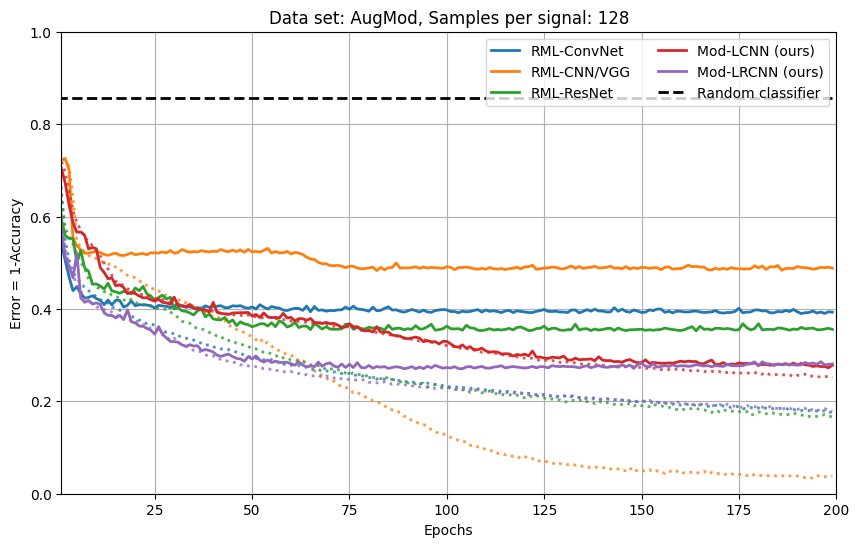

In [29]:
plt.figure(figsize=(10, 6))

for name_network in networks_to_plot:

    data = np.loadtxt(
        join(
            log_path,
            "history-{}-{}-trained{}.txt".format(
                dataset_name, name_network, signal_duration
            ),
        )
    )

    p = plt.plot(
        data[:, 0],
        1.0 - data[:, 1],
        label=from_name_to_legend[name_network],
        linewidth=2,
    )
    plt.plot(
        data[:, 0],
        1.0 - data[:, 2],
        ":",
        linewidth=2,
        color=p[0].get_color(),
        alpha=0.8,
    )

plt.plot(
    data[:, 0],
    1.0 - 1.0 / output_shp * np.ones_like(data[:, 0]),
    "--",
    label="Random classifier",
    linewidth=2,
    color="black",
)

plt.legend(ncol=2, loc=1)
plt.grid()
plt.ylabel("Error = 1-Accuracy")
plt.xlabel("Epochs")
plt.title(f"Data set: {dataset_name}, Samples per signal: {signal_duration}")
plt.ylim([0.0, 1.0])
plt.xlim([1, nb_epoch])
plt.savefig(
    join(
        log_path,
        "network_comparison_{}-trained{}.pdf".format(dataset_name, signal_duration),
    )
)
plt.show()

Solid curves are for the test set and dotted curves for the training set

Lower is better

### Print final performances

Displays test accuracy for different algorithmes and train/test computation time

In [30]:
f = open(
    join(
        log_path,
        "perfs-{}-{}-trained{}.txt".format(dataset_name, "all", signal_duration),
    ),
    "w",
)

f.write(
    f"#Performance evaluations, Data set: {dataset_name}, Samples per signal: {signal_duration}\n"
)

f.write(
    f"#{'':20s}{'Loss':15s}{'Accuracy':15s}{'Training time':20s}{'Inference time':20s}{'# Parameters':15s}\n"
)
f.write(f"#{'':20s}{'':15s}{'':15s}{'(s/epoch)':20s}{'(ms/signal)':20s}\n")
f.write(f"#{'-'*110}\n")

for name_network in networks_to_plot:

    training_time_vec = np.loadtxt(
        join(
            log_path,
            "history_time-{}-{}-trained{}.txt".format(
                dataset_name, name_network, signal_duration
            ),
        )
    )
    training_time = training_time_vec[:, 1].mean()

    print(
        join(
            log_path,
            "model-{}-{}-trained{}.h5".format(
                dataset_name, name_network, signal_duration
            ),
        )
    )

    model = load_model(
        join(
            log_path,
            "model-{}-{}-trained{}.h5".format(
                dataset_name, name_network, signal_duration
            ),
        ),
        compile=True,
    )
    mod_size = model.count_params()

    t = time.time()
    test_loss, test_acc = model.evaluate(
        X_test, y_test, verbose=False, batch_size=batch_size
    )
    t_proc = 1000.0 * (time.time() - t) / X_test.shape[0]  # ms

    f.write(
        f"{from_name_to_legend[name_network]:20s}{test_loss:2.3f}{'':10s}{test_acc:2.3f}{'':10s}{training_time:>4.1f}{'':17s}{t_proc:>4.2}{'':16s}{mod_size:>10,d}\n"
    )

f.close()

/home/helion/xp/log_modreco/tests/model-AugMod-RMLConvNet-trained128.h5
/home/helion/xp/log_modreco/tests/model-AugMod-RMLCNNVGG-trained128.h5
/home/helion/xp/log_modreco/tests/model-AugMod-RMLResNet-trained128.h5
/home/helion/xp/log_modreco/tests/model-AugMod-LModCNN-trained128.h5
/home/helion/xp/log_modreco/tests/model-AugMod-LModCNNResNetRelu-trained128.h5


In [31]:
f = open(
    join(
        log_path,
        "perfs-{}-{}-trained{}.txt".format(dataset_name, "all", signal_duration),
    ),
    "r",
)
print(f.read())
f.close()

#Performance evaluations, Data set: AugMod, Samples per signal: 128
#                    Loss           Accuracy       Training time       Inference time      # Parameters   
#                                                  (s/epoch)           (ms/signal)         
#--------------------------------------------------------------------------------------------------------------
RML-ConvNet         0.898          0.607           7.2                 0.021                 2,829,399
RML-CNN/VGG         3.698          0.512           3.6                 0.015                   199,111
RML-ResNet          2.066          0.644           8.7                 0.026                   179,303
Mod-LCNN (ours)     0.653          0.722           2.3                 0.012                    37,487
Mod-LRCNN (ours)    0.984          0.719           4.9                 0.022                    97,663



In [32]:
clear_session()